![](https://zupimages.net/up/19/09/1gz8.png)

# Estimation du nombre de copies de gènes avec des modèles de Markov cachés
# *Projet d'approfondissement MAP512*
# *Rayan Charrier, Fang Ting Goh, Sofiane Hadji*
# *Janvier-Mars 2019*
--------------

Ce notebook contient l'essentiel du code du projet. Il ne s'attarde pas sur les aspects théoriques qui sont présentés plus en détail dans le rapport.

<br/>

L'objectif est ici de prédire le nombre de copies de gènes à partir d'observations expérimentales$^{[1]}$.


On considère le modèle de Markov caché suivant$^{[2]}$ :

* 3 états $X_1, X_2, X_3$ : copie du gène, délétion ou aucune modification

* observations $Y_t$ ~ $\mathcal{N}$($\mu_i$, $\nu_i ^2$) avec $X_t = i$ (paramètres de la gaussienne dépendant de l'état caché).

<br/>

Pour retrouver les états cachés $X_t$ à partir des observations $Y_t$ nous utilisons un algorithme d'apprentissage.

Nous avons commencé par implémenter cet algorithme dans le cas plus simple de deux états, et nous avons simulé des données afin d'évaluer les performances de l'algorithme.

Nous sommes ensuite passés à trois états et nous avons appliqué cet algorithme aux données expérimentales.

<br/>

In [47]:
# importation des librairies nécessaires

import numpy as np
import numpy.random as rd
import scipy.stats as ss
from matplotlib import pyplot as plt
import time
import pandas as pd

## Simulation d'une chaîne de Markov cachée

### Simulation des états

In [3]:
def simulation_etats_markov(k, Q, nu, n):
    """ Retourne une liste de n états pour une chaine de Markov de matrice
         de transition Q et probabilités initiales nu"""
    
    etats = list(range(k))
    
    X = [0] * n
    X[0] = rd.choice(etats, p = nu)
    
    for i in range(1, n):
        X[i] = rd.choice(etats, p = Q[X[i-1]])
    
    return X       

### Simulation des observations

In [4]:
def simulation_etats_obs(k, Q, nu, esperances, variances, n):
    """ Simulation d'états et d'observations en supposant tous les paramètres connus"""
    
    #gestion des erreurs
    if len(Q) != k or len(Q[0]) != k :
        raise ValueError("Q n'est pas de taille k x k")
    elif len(esperances) != k :
        raise ValueError("esperances n'est pas de taille k")
    elif len(variances) != k :
        raise ValueError("variances n'est pas de taille k")
    
    sigma = [x**0.5 for x in variances]
    
    X = simulation_etats_markov(k, Q, nu, n)
    
    Y = [ esperances[X[t]] + sigma[X[t]] * rd.randn() for t in range(n)]
        
    return(X,Y)

### Visualisation graphique des paramètres

In [58]:
def dessiner_gaussiennes(esperances, variances):
    plt.clf()
    
    n = len(esperances)
    couleurs = ["r", "b", "g"]
    
    x = [list(np.linspace(esperances[i]-5*(variances[i]**0.5),esperances[i]+5*(variances[i]**0.5),1000)) for i in range(n)]
    y = [[ss.norm.pdf(f,esperances[i], variances[i]**0.5) for f in x[i]] for i in range(n)]
    
    if n==3:
        for i in range(n):
            plt.plot(x[i], y[i], label = "Etat " + str(i), color = couleurs[i])
    else:
        for i in range(n):
            plt.plot(x[i], y[i], label = "Etat " + str(i))
    
    plt.title("Densités")
    plt.legend()   
    plt.show()

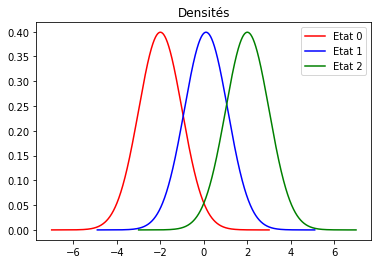

In [59]:
dessiner_gaussiennes([-2,0.1,2], [1,1,1])

## Algorithme d'apprentissage (deux états)

L'algorithme est itératif. On procède aux deux opérations suivantes à chaque itération :

* **estimation des paramètres** de la chaîne de Markov en supposant les états $(X_t)$ connus *(on effectue en réalité un tirage aléatoire selon une loi estimée à partir des $(X_t)$ de l'itération précédente)*
* **estimation des états** $(X_t)$ en supposant tous les paramètres connus.


### Echantillonneur de Gibbs

On cherche ici à estimer les paramètres du modèle de Markov caché en supposant les états $X_t$ connus (en plus des observations $Y_t$).


On suppose le modèle suivant dans le cas de deux états :
* matrice de transition $Q = \begin{bmatrix} q1 & {1-q1} \\ {1-q2} & q2 \end{bmatrix}$
* $Y \ | \ X = i \ \ \ $ ~ $ \ \  \mathcal{N}$($mu_i$, $va_i$)

On suppose les distributions **a prioiri** suivantes :
* $q1, \ q2 \ $ ~ $ \ \beta(a,b)$
* $mu1, \ mu2 \ $ ~ $ \ \mathcal{N}(m, v)$
* $va1, \ va2 \ $ ~ $ \ InvGamma(c,d)$

In [6]:
def posteriori_deux_etats(X, Y, n, q1, q2, mu1, mu2, va1, va2,  a,b,m,v,c,d):    
    """calcul des paramètres en fonction des états/observations"""

        
    # q1
    
    a_1 = len([t for t in range(n-1) if (X[t]==0 and X[t+1]==0)])
    b_1 = len([t for t in range(n-1) if (X[t]==0 and X[t+1]==1)])
    
    q1_new = rd.beta(a + a_1, b + b_1)
    
    # q2
    
    a_2 = len([t for t in range(n-1) if (X[t]==1 and X[t+1]==1)])     
    b_2 = len([t for t in range(n-1) if (X[t]==1 and X[t+1]==0)])     
    
    q2_new = rd.beta(a + a_2, b + b_2)
    
    
    
    
    (mu1_new, mu2_new) = (1,0)
    
    while mu1_new > mu2_new:   # on veut éviter tout problème de label switching
    
        # mu1
        
        E1  = [Y[i] for i in range(n) if X[i] == 0]
        N   = len(E1)
        S   = sum(E1)
        m_1 = (m/v + S/va1) / (1/v + N/va1)
        v_1 = 1 / (1/v + N/va1)
        
        mu1_new = rd.normal(m_1, v_1**0.5)
        
        # mu2
        
        E2  = [Y[i] for i in range(n) if X[i] == 1]
        N   = len(E2)
        S   = sum(E2)
        m_2 = (m/v + S/va2) / (1/v + N/va2)
        v_2 = 1 / (1/v + N/va1)
        
        mu2_new = rd.normal(m_2, v_2**0.5)
    
    
    
    # va1
    
    S_bis = sum([(y - mu1_new)**2 for y in E1])
    c_1   = c + 0.5*N
    d_1   = d + 0.5*S_bis
    
    va1_new = 1 / rd.gamma(c_1, 1/d_1)

    # va2
    
    S_bis = sum([(y - mu2_new)**2 for y in E2])
    c_2   = c + 0.5*N
    d_2   = d + 0.5*S_bis
    
    va2_new = 1 / rd.gamma(c_2, 1/d_2)
    
    ## corriger les N
    return (q1_new, q2_new, mu1_new, mu2_new, va1_new, va2_new)

### Forward et Backward

On cherche ensuite à estimer les états $(X_t)$ en supposant les paramètres de la chaîne connus.

#### Coefficients alpha et beta

L'algorithme commence par calculer récursivement les coefficients $(\alpha_t)_{1 \leq t \leq n}$ et $(\beta_t)_{1 \leq t \leq n}$ qui correspondent intuitivement aux quantités suivantes :

* $\alpha_t (y_{0:t}, x)$   : $p(Y_0 = y_0, . . . , Y_t = y_t, X_t = x)$
* $\beta_t (y_{t+1:n}, x) $ : $p(Y_{t+1} = y_{t+1}, . . . , Y_n = y_n \ | \ X_t = x)$ ,

$p$ pouvant désigner une probabilité ou une densité.

<br/>

*(On calcule $\alpha$ et $\beta$ avec $t$ respectivement croissant et décroissant)*

Par ailleurs, comme les coefficients $\alpha$ et $\beta$ ont tendance à tendre vers $0$ ou vers $+ \infty$ exponentiellement vite, on les normalise à chaque étape (coefficients $c$ dans l'algorithme).

In [7]:
def alpha_beta(Y, k, Q, nu, esperances, variances):
    """ algorithme forward-backward avec normalisation"""
    
    sigma = [x**0.5 for x in variances]
    n = len(Y)
    
    # normalisation
    c = [0 for i in range(n)]
    c[0] = sum([nu[i] * ss.norm.pdf(Y[0], esperances[i], sigma[i]) for i in range(k)])
    
    
     #forward
    alpha = [list(range(k)) for t in range(n)]
 
    alpha[0] = [nu[i]*ss.norm.pdf(Y[0], esperances[i], sigma[i]) / c[0] for i in range(k)]
    
    for t in range(1,n):
        m = [ sum( [alpha[t-1][i]*Q[i][ibis]*ss.norm.pdf(Y[t], esperances[ibis], sigma[ibis]) for i in range(k)] ) for ibis in range(k)]
        c[t] = sum(m)
        # formule (3.22) avec k <- t
        
        for j in range(k):
            alpha[t][j] = ss.norm.pdf(Y[t], esperances[j], sigma[j]) * sum([alpha[t-1][i]*Q[i][j] for i in range(k)]) / c[t]
            # formule (3.22) avec x <- j, x' <- i et k <- t

    # backward    
    beta = [list(range(k)) for t in range(n)]
    beta[n-1] = [1 for i in range(k)]
    
    for t in range(n-2,-1,-1):
        for j in range(k):
            beta[t][j] = sum([beta[t+1][i]*Q[j][i]*ss.norm.pdf(Y[t+1], esperances[i], sigma[i]) 
                                for i in range(k)]) / c[t+1]
            # formule (3.23) avec x <- j, x' <- i et k <- t

    return (alpha, beta)

#### Lois marginales

Même si ce n'est pas ce qui nous intéresse en premier lieu, on peut accessoirement retouver les lois marginales des états cachés car
<center> $p(X_t = x)$ est proportionnel à $\alpha_t(x) \times \beta_t(x)$ </center>.

La fonction _**guess**_ utilise ces lois pour retourner l'état le plus probable à chaque instant $t$.

In [8]:
def guess(Y, k, Q, nu, esperances, variances):
    n = len(Y)
    
    (alpha, beta) = alpha_beta(Y, k, Q, nu, esperances, variances)

    probas = [ [alpha[t][i]*beta[t][i] for i in range(k)] for t in range(n)]
    
    etats = [probas[t].index(max(probas[t])) for t in range(n)]

    return etats

La fonction * ** evaluation\_guess** * simule une liste d'états et d'observations pour évaluer les performances de la fonction _**guess**_.

In [9]:
def evaluation_guess():

    # INITIALISATION DES PARAMETRES
    
    k = 2                        # nombre d'états
    
    Q = [[0.7, 0.3], [0.4, 0.6]] # matrice de transition
    nu = [0.5, 0.5]              # probabilité de l'état de départ
    
    esperances = [0, 7]          # espérances lois normales
    variances = [4, 1]           # variances lois normales
    
    n = 100                      # nombre d'observations
    
    
       
    # CALCULS
        
    (X,Y) = simulation_etats_obs(k, Q, nu, esperances, variances, n)
    etats_predits =  guess(Y, k, Q, nu, esperances, variances)
    
    correction = [0 for i in range(n)]
    for i in range(n):
        correction[i] = abs(X[i] - etats_predits[i])
    
    print("Pourcentage d'états bien prédits :" + str(correction.count(0)/n * 100) + "%")
    
    
        # AFFICHAGE GRAPHIQUE
    
    plt.clf()
    
    plt.suptitle("Prédiction des états sachant les observations")
    plt.title("Précision : " + str(correction.count(0)/n * 100) + "%", fontsize=10)
    
    plt.plot(list(range(n)), X, "ro", linewidth=0.8, color = "sandybrown", label="Originaux")
    plt.plot(list(range(n)), [x + 0.05 for x in etats_predits], "ro", linewidth=0.8, color = "orchid", label="Prédits")
    
    flag = False
    for i in range(n) :
        if correction[i] != 0 and not flag:
            plt.axvline(x=i, color='powderblue', linewidth=1.5, label="Erreur")
            flag = True
        if correction[i] != 0 and flag:
            plt.axvline(x=i, color='powderblue', linewidth=1.5)
            
    
    plt.xlabel("Temps")
    plt.ylabel("Etat")
    axes = plt.gca()
    axes.yaxis.set_ticks(range(k))
    
    
    plt.legend()
    plt.show()

#### Loi jointe

Pour estimer les états $(X_t)$ on cherche en réalité à évaluer $p(X_1 = x_1, ..., X_n = x_n)$ en supposant les paramètres du modèles connus. Il s'agit donc de retrouver la loi jointe des états cachés et non les lois marginales.

On utilise pour cela la formule de Bayes qui nous donne :
<center>$p(X_1 = x_1, ..., X_n = x_n) \ = \ p(X_1 = x_1) \ p(X_2 = x_2 \ | \  X_1 = x_1) \ ... \ p(X_n = x_n \ | \ X_{n-1} = x_{n-1} \ ... \ X_1 = x_1) $</center>

On calcule chacun des facteurs grâce aux $\alpha_t (x)$ et $\beta_t (x)$ précédents.

In [10]:
def forward_et_backward(Y, k, Q, nu, esperances, variances):
    n = len(Y)
    
    etats = list(range(k))
    sigma = [x**0.5 for x in variances]
    
    (alpha, beta) = alpha_beta(Y, k, Q, nu, esperances, variances)
    
    X = [0 for i in range(n)]
    
    probas_depart = [alpha[0][i]*beta[0][i] for i in range(k)]
    
    X[0] = rd.choice(etats, p = probas_depart/sum(probas_depart))
        
    
    for t in range(1,n):
        probas = [0 for i in range(k)]
        
        if beta[t-1][X[t-1]] == 0:
            probas = [0]*k
        
        else:
            for i in range(k):
                probas[i] = (1/beta[t-1][X[t-1]]) * Q[X[t-1]][i] * beta[t][i] * ss.norm.pdf(Y[t], esperances[i], sigma[i])
                # formule (3.30) avec x <- X[t-1], x' <- i et k <- t-1 
        
        
        # on utilise les betas calculés avec la fonction alpha_beta qui sont
        # des betas normalisés et pas les betas originaux
        # d'où besoin de compenser cela pour utiliser la formule (3.30)
        s = sum(probas)
        probas = [x/s for x in probas]
        
        X[t] = rd.choice(etats, p = probas)
        
    return X

### Application de l'algorithme à chaîne à deux états

On code ici l'algorithme pour une chaîne de Markov cachée à deux états, avec $L$ itérations.

In [11]:
def apprentissage_deux_etats(a,b,m,v,c,d,   Y, L=1000):
    
    k=2
    nu  = [1/k for i in range(k)]
    
    q1  = [0.5 for i in range(L)]
    q2  = [0.5 for i in range(L)]
    mu1 = [m   for i in range(L)]
    mu2 = [m   for i in range(L)]
    va1 = [0.3 for i in range(L)]
    va2 = [0.3 for i in range(L)]
    
    n = len(Y)
    
    
    # temps à partir duquel on retient les valeurs rencontrées
    if L < 2000 :
        L0 = int(L/10)
    else:
        L0 = 1000
    
    
    
    # optimisation (plutôt que de stocker toutes les valeurs de X, on retient le nombre pour chaque état)
    X_comptage = [[0 for i in range(k)] for i in range(n)]
    
    for l in range(1, L):
    
        # etats selon les paramètres
        Q = [[q1[l-1], 1-q1[l-1]], [1-q2[l-1], q2[l-1]]]
        X = forward_et_backward(Y, k, Q, nu, [mu1[l-1], mu2[l-1]], [va1[l-1], va2[l-1]])
        
        # paramètres selon les etats
        (q1[l], q2[l], mu1[l], mu2[l], va1[l], va2[l]) = posteriori_deux_etats(X, Y, n, q1[l-1], q2[l-1],
                                                                    mu1[l-1], mu2[l-1], va1[l-1], va2[l-1],
                                                                    a,b,m,v,c,d)
        # optimisation
        if l >= L0:
            for t in range(n):
                X_comptage[t][X[t]] = X_comptage[t][X[t]] + 1
            
    
    
    # choix de X (état le plus probable)
    X = [X_comptage[t].index(max(X_comptage[t])) for t in range(n)]
    
    
    # valeurs des paramètres retenues
    q1  =  q1[L0:L]
    q2  =  q2[L0:L]
    mu1 = mu1[L0:L]
    mu2 = mu2[L0:L]
    va1 = va1[L0:L]
    va2 = va2[L0:L]
    
    return(X, q1, q2, mu1, mu2, va1, va2)

On évalue ensuite les performances de l'algorithme.

In [12]:
def evaluation_algo_deux_etats(n=100, L=1000, N = 5):
    
    precision_X   = [0 for i in range(N)]
    precision_q1  = [0 for i in range(N)]
    precision_q2  = [0 for i in range(N)]
    precision_mu1 = [0 for i in range(N)]
    precision_mu2 = [0 for i in range(N)]
    precision_va1 = [0 for i in range(N)]
    precision_va2 = [0 for i in range(N)]
    
    # paramètres pour la génération des valeurs originales 
    a = 5
    b = 2
    m = 0
    v = 1
    c = 2
    d = 1
    
    
    # on veut stocker les paramètres calculés pour la meilleure estimation
    best = []
    precision_best = 0
    
    
    
    for i in range(N):
        # calcul du temps
        t = time.time()
        
        # génération des valeurs originales
        (q1, q2) =(0, 0)
        while q1 < 0.6 or q2 < 0.6 :
            q1 = rd.beta(a,b)
            q2 = rd.beta(a,b)
        
        va1  = 1 / rd.gamma(c, 1/d)
        va2  = 1 / rd.gamma(c, 1/d)
        
        (mu1, mu2) = (1, 0) # valeurs intiales pour rentrer dans la boucle
        while (mu1+0.4*va1) > (mu2-0.4*va2):
            # on ne veut pas des moyennes trop proches pour les tests
            
            mu1 = rd.normal(m,v)
            mu2 = rd.normal(m,v)
            
        
        
        (X, Y) = simulation_etats_obs(2, [[q1, 1-q1], [1-q2, q2]], [0.5, 0.5], [mu1, mu2], [va1,va2], n)
        
        # calcul des valeurs prédites
        (X_bis, q1_app, q2_app, mu1_app, mu2_app, va1_app, va2_app) = apprentissage_deux_etats(a,b,m,v,c,d,  Y,L)
        
        q1_bis  = np.mean( q1_app)
        q2_bis  = np.mean( q2_app)
        mu1_bis = np.mean(mu1_app)
        mu2_bis = np.mean(mu2_app)
        va1_bis = np.mean(va1_app)
        va2_bis = np.mean(va2_app)
        
        
        # comparaison des valeurs originales et des valeurs prédites
        precision_X[i]   = [abs(X[i] - X_bis[i]) for i in range(n)].count(0)/n
        precision_q1[i]  = (q1  - q1_bis ) /q1
        precision_q2[i]  = (q2  - q2_bis ) /q2
        precision_mu1[i] = (mu1 - mu1_bis) /mu1
        precision_mu2[i] = (mu2 - mu2_bis) /mu2
        precision_va1[i] = (va1 - va1_bis) /va1
        precision_va2[i] = (va2 - va2_bis) /va2
    
        # affichage d'informations pour l'utilisateur
        print(str(i+1) + "-ème simulation calculée en " + str(int((time.time() - t)/60)) + " mins")
        
        param = [q1, q2, mu1, mu2, va1, va2]
        param = [str(round(x,2)) for x in param]
        print("q1 = " + param[0] + ", q2 = " + param[1] + ", mu1 = " + param[2] + ", mu2 = " + param[3] + ", va1 = " + param[4] + ", va2 = " + param[5])
        print()
        
        # stockage des paramètres si la précision est meilleure
        if precision_X[i] > precision_best:
            best = [q1_app, q2_app, mu1_app, mu2_app, va1_app, va2_app]
            precision_best = precision_X[i]
        
    
    # affichage precisions
    print()
    print("Précisions")
    print()
    print("X : "  , [round(x,2) for x in precision_X  ])
    print()
    print("q1 : " , [round(x,2) for x in precision_q1 ])
    print()
    print("q2 : " , [round(x,2) for x in precision_q2 ])
    print()
    print("mu1 : ", [round(x,2) for x in precision_mu1])
    print()
    print("mu2 : ", [round(x,2) for x in precision_mu2])
    print()
    print("va1 : ", [round(x,2) for x in precision_va1])
    print()
    print("va2 : ", [round(x,2) for x in precision_va2])
    
    
    # affichage graphique
    
        # précision des états
        
    plt.plot(list(range(N)), precision_X, label = "Etats")
    plt.title("Précision - états")
    
    axes = plt.gca()
    axes.xaxis.set_ticks(range(N))
    axes.yaxis.set_ticks([x/10 for x in range(11)])
    
    plt.legend()
    plt.show()
    
        # précision relative des paramètres
        
    plt.figure(2)
    
    plt.plot(list(range(N)), precision_q1 , label = "q1",  color = "r")
    plt.plot(list(range(N)), precision_q2 , label = "q2",  color = "y")
    plt.plot(list(range(N)), precision_mu1, label = "mu1", color = "b")
    plt.plot(list(range(N)), precision_mu2, label = "mu2", color = "c")
    plt.plot(list(range(N)), precision_va1, label = "va1", color = "darkviolet")
    plt.plot(list(range(N)), precision_va2, label = "va2", color = "fuchsia")
    
    plt.title("Précision relative - paramètres")
    axes = plt.gca()
    axes.xaxis.set_ticks(range(N))
    
    plt.legend()
    plt.show()
    
        # histogramme de la répartition des paramètres
           
    plt.figure(3)
    plt.hist(best[0], color = "r")
    plt.suptitle("Répartition des q1")
    plt.title("Précision pour les états : " + str(int(100*precision_best)) + "%")
    plt.legend()
    plt.show()
    
    plt.figure(4)
    plt.hist(best[1], color = "y")
    plt.suptitle("Répartition des q2")
    plt.title("Précision pour les états : " + str(int(100*precision_best)) + "%")
    plt.legend()
    plt.show()
    
    plt.figure(5)
    plt.hist(best[2], color = "b")
    plt.suptitle("Répartition des mu1")
    plt.title("Précision pour les états : " + str(int(100*precision_best)) + "%")
    plt.legend()
    plt.show()
    
    plt.figure(6)
    plt.hist(best[3], color = "c")
    plt.suptitle("Répartition des mu2")
    plt.title("Précision pour les états : " + str(int(100*precision_best)) + "%")
    plt.legend()
    plt.show()
    
    plt.figure(7)
    plt.hist(best[4], color = "darkviolet")
    plt.suptitle("Répartition des va1")
    plt.title("Précision pour les états : " + str(int(100*precision_best)) + "%")
    plt.legend()
    plt.show()
    
    plt.figure(8)
    plt.hist(best[5], color = "fuchsia")
    plt.suptitle("Répartition des va2")
    plt.title("Précision pour les états : " + str(int(100*precision_best)) + "%")
    plt.legend()
    plt.show()

In [26]:
evaluation_algo_deux_etats(L=10000, N=10)

KeyboardInterrupt: 

## Application de l'algorithme aux données expérimentales (trois états)

On suppose maintenant le modèle suivant :

* matrice de transition $Q = \begin{bmatrix} {1-\rho} & {\frac \rho 2} & {\frac \rho 2} \\ {\frac \rho 2} & {1-\rho} & {\frac \rho 2} \\ {\frac \rho 2} & {\frac \rho 2} & {1-\rho} \end{bmatrix}$
* $Y \ | \ X = i \ \ \ $ ~ $ \ \  \mathcal{N}$($mu_i$, $va_i$)

On suppose les distributions **a priori** suivantes :
* $\rho \ $ ~ $ \ \beta(a,b)$
* $mu1, \ mu2, \ mu3 \ $ ~ $ \ \mathcal{N}(m, v)$
* $va1, \ va2, \ va3 \ $ ~ $ \ InvGamma(c,d)$

### Algorithme d'apprentissage (trois états)

Les algorithmes forward et backward sont les mêmes, seul l'algorithme MCMC (échantillonage de Gibbs) change.

In [13]:
def posteriori_trois_etats(X, Y, n, rho, mu1, mu2, mu3, va1, va2, va3,  a,b,m,v,c,d):    
    """calcul des paramètres en fonction des états/observations"""

        
    # rho
    
    a_1 = len([t for t in range(n-1) if (X[t] != X[t+1])])
    b_1 = len([t for t in range(n-1) if (X[t] == X[t+1])])
    
    rho_new = rd.beta(a + a_1, b + b_1)
    
    
    
    (mu1_new, mu2_new, mu3_new) = (2,1,0)
    
    while mu1_new > mu2_new or mu2_new > mu3_new :   # on veut éviter tout problème de label switching
    
        # mu1
        
        E1  = [Y[i] for i in range(n) if X[i] == 0]
        N   = len(E1)
        S   = sum(E1)
        m_1 = (m/v + S/va1) / (1/v + N/va1)
        v_1 = 1 / (1/v + N/va1)
        
        mu1_new = rd.normal(m_1, v_1**0.5)
        
        # mu2
        
        E2 = [Y[i] for i in range(n) if X[i] == 1]
        N   = len(E2)
        S   = sum(E2)
        m_2 = (m/v + S/va2) / (1/v + N/va2)
        v_2 = 1 / (1/v + N/va2)
        
        mu2_new = rd.normal(m_2, v_2**0.5)
        
        # mu3
        
        E3  = [Y[i] for i in range(n) if X[i] == 2]
        N   = len(E3)
        S   = sum(E3)
        m_3 = (m/v + S/va3) / (1/v + N/va3)
        v_3 = 1 / (1/v + N/va3)
        
        mu3_new = rd.normal(m_3, v_3**0.5)
    
    
    
    # va1
    
    N = len(E1)
    S_bis = sum([(y - mu1_new)**2 for y in E1])
    c_1   = c + 0.5*N
    d_1   = d + 0.5*S_bis
    
    va1_new = 1 / rd.gamma(c_1, 1/d_1)

    # va2
    
    N = len(E2)
    S_bis = sum([(y - mu2_new)**2 for y in E2])
    c_2   = c + 0.5*N
    d_2   = d + 0.5*S_bis
    
    va2_new = 1 / rd.gamma(c_2, 1/d_2)
    
    # va3
    
    N = len(E3)
    S_bis = sum([(y - mu3_new)**2 for y in E3])
    c_3   = c + 0.5*N
    d_3   = d + 0.5*S_bis
    
    va3_new = 1 / rd.gamma(c_3, 1/d_3)
    
    
    return (rho_new, mu1_new, mu2_new, mu3_new, va1_new, va2_new, va3_new)

Il faut alors aussi adapter l'algorithme d'apprentissage...

In [14]:
def apprentissage_trois_etats(a,b,m,v,c,d,   Y, L=10000, X_origin = []):
    
    k=3
    nu  = [1/k for i in range(k)]
    
    rho = [0.15 for i in range(L)]
    mu1 = [m-v for i in range(L)]
    mu2 = [m   for i in range(L)]
    mu3 = [m+v for i in range(L)]
    va1 = [0.3 for i in range(L)]
    va2 = [0.3 for i in range(L)]
    va3 = [0.3 for i in range(L)]
    
    n = len(Y)
    liste_precision = []
    
    
    # temps à partir duquel on retient les valeurs rencontrées
    if L < 2000 :
        L0 = int(L/10)
    else:
        L0 = 1000
    
    
    # optimisation (plutôt que de stocker toutes les valeurs de X, on retient le nombre pour chaque état)
    X_comptage = [[0 for i in range(k)] for i in range(n)]
    
    for l in range(1, L):
    
        # etats selon les paramètres
        Q = [[1-rho[l-1], rho[l-1]/2, rho[l-1]/2], [rho[l-1]/2, 1-rho[l-1], rho[l-1]/2], [rho[l-1]/2, rho[l-1]/2, 1-rho[l-1]]]
        X = forward_et_backward(Y, k, Q, nu, [mu1[l-1], mu2[l-1], mu3[l-1]], [va1[l-1], va2[l-1], va3[l-1]])
        
        # paramètres selon les etats
        (rho[l], mu1[l], mu2[l], mu3[l], va1[l], va2[l], va3[l]) = posteriori_trois_etats(X, Y, n, rho[l-1],
                                                                    mu1[l-1], mu2[l-1], mu3[l-1], va1[l-1], va2[l-1], va3[l-1],
                                                                    a,b,m,v,c,d)
        # optimisation
        if l >= L0:
            for t in range(n):
                X_comptage[t][X[t]] = X_comptage[t][X[t]] + 1
        
        # précision sur les états
        if X_origin != []:
            liste_precision += [[(X[i] - X_origin[i]) for i in range(n)].count(0)/n]  
  
    return(X_comptage, rho, mu1, mu2, mu3, va1, va2, va3, liste_precision)

... et évaluer ses performances.

In [43]:
def affichage_graphique_resultats(indice_best, precision_best, L0,
                                  rho, mu1, mu2, mu3, va1, va2, va3,
                                  rho_vrai, esperances, variances):
    
    base = 7
    n = len(rho[L0:])
    i1 = int(n*2.5/100)
    i2 = int(n*95/100)
    
    
    
    ## rho
    
    tri = sorted(rho[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base)
    plt.hist(rho[L0:], color = "darkviolet", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des rho")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=rho_vrai, color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='darkviolet', label = "Quantiles 95%")
    plt.axvline(x=q2, color='darkviolet', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+1)
    plt.plot(rho, color = "darkviolet")
    plt.suptitle("Evolution de rho")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()
    
    
    
    ## mu1
    
    tri = sorted(mu1[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base+2)
    plt.hist(mu1[L0:], color = "r", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des mu1")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=esperances[0],color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='r', label = "Quantiles 95%")
    plt.axvline(x=q2, color='r', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+3)
    plt.plot(mu1, color = "r")
    plt.suptitle("Evolution de mu1")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()
    
    
    
    ## mu2
    
    tri = sorted(mu2[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base+4)
    plt.hist(mu2[L0:], color = "b", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des mu2")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=esperances[1],color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='b', label = "Quantiles 95%")
    plt.axvline(x=q2, color='b', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+5)
    plt.plot(mu2, color = "b")
    plt.suptitle("Evolution de mu2")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()
    
    
    
    ## mu3
    
    tri = sorted(mu3[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base+6)
    plt.hist(mu3[L0:], color = "g", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des mu3")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=esperances[2],color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='g', label = "Quantiles 95%")
    plt.axvline(x=q2, color='g', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+7)
    plt.plot(mu3, color = "g")
    plt.suptitle("Evolution de mu3")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()
    
    
    
    ## va1
    
    tri = sorted(va1[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base+8)
    plt.hist(va1[L0:], color = "r", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des va1")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=variances[0],color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='r', label = "Quantiles 95%")
    plt.axvline(x=q2, color='r', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+9)
    plt.plot(va1, color = "r")
    plt.suptitle("Evolution de va1")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()
    
    
    
    ## va2
    
    tri = sorted(va2[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base+10)
    plt.hist(va2[L0:], color = "b", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des va2")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=variances[1],color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='b', label = "Quantiles 95%")
    plt.axvline(x=q2, color='b', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+11)
    plt.plot(va2, color = "b")
    plt.suptitle("Evolution de va2")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()
    
    
    
    ## va3
    
    tri = sorted(va3[L0:])
    q1 = tri[i1]
    q2 = tri[i2]
    
    plt.figure(base+12)
    plt.hist(va3[L0:], color = "g", label = "Prédiction", bins = 30)
    plt.suptitle("Répartition des va3")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.axvline(x=variances[2],color='black', label = "Valeur à prédire")
    plt.axvline(x=q1, color='g', label = "Quantiles 95%")
    plt.axvline(x=q2, color='g', label = "")
    plt.legend()
    plt.show()
    
    print("Intervalle de crédibilité à 95% : [" + str(round(q1,2)) + " , " + str(round(q2,2)) + "]")
    
    plt.figure(base+13)
    plt.plot(va3, color = "g")
    plt.suptitle("Evolution de va3")
    plt.title("Simulation " + indice_best + " (" + precision_best + "%)")
    plt.legend()
    plt.show()

In [29]:
def evaluation_algo_trois_etats(n=100, L=10000, N = 1,
                                rho_choisi = [0.3], esperances_choisi = [-5,0,5], variances_choisi = [1,1,1]):
    
    precision_X   = [0 for i in range(N)]
    precision_rho = [0 for i in range(N)]
    precision_mu1 = [0 for i in range(N)]
    precision_mu2 = [0 for i in range(N)]
    precision_mu3 = [0 for i in range(N)]
    precision_va1 = [0 for i in range(N)]
    precision_va2 = [0 for i in range(N)]
    precision_va3 = [0 for i in range(N)]
    
    # paramètres pour la génération des valeurs originales 
    a = 0.5
    b = 1.1
    m = 0
    v = 1
    c = 2
    d = 1
    
    
    # temps à partir duquel on retient les valeurs rencontrées
    if L < 2000 :
        L0 = int(L/10)
    else:
        L0 = 1000
        
        
    # on veut stocker les paramètres calculés pour la meilleure estimation
    precision_best = 0
    
    
    for i in range(N):
        # calcul du temps
        t = time.time()
        
        # simulation de X et Y
        rho = rho_choisi[i]        
            
        (X, Y) = simulation_etats_obs(3, [[1-rho, rho/2, rho/2], [rho/2, 1-rho, rho/2], [rho/2, rho/2, 1-rho]],
                                      [1/3, 1/3, 1/3], esperances_choisi[i], variances_choisi[i], n)
        
        
        # calcul des valeurs prédites
        (X_comptage, rho_app, mu1_app, mu2_app, mu3_app, va1_app, va2_app, va3_app, liste_precision) = apprentissage_trois_etats(
                                                                                                            a,b,m,v,c,d,
                                                                                                            Y,L,X)
        X_bis = [X_comptage[t].index(max(X_comptage[t])) for t in range(n)]
        
        rho_bis = np.mean(rho_app[L0:L])
        mu1_bis = np.mean(mu1_app[L0:L])
        mu2_bis = np.mean(mu2_app[L0:L])
        mu3_bis = np.mean(mu3_app[L0:L])
        va1_bis = np.mean(va1_app[L0:L])
        va2_bis = np.mean(va2_app[L0:L])
        va3_bis = np.mean(va3_app[L0:L])
        
        
        # pour un souci de clarté
        mu1 = esperances_choisi[i][0]
        mu2 = esperances_choisi[i][1]
        mu3 = esperances_choisi[i][2]
        va1 = variances_choisi[i][0]
        va2 = variances_choisi[i][1]
        va3 = variances_choisi[i][2]
        
        
        # comparaison des valeurs originales et des valeurs prédites
        precision_X[i]   = [(X[i] - X_bis[i]) for i in range(n)].count(0)/n
        precision_rho[i] = (rho - rho_bis)/rho_bis
        precision_mu1[i] = (mu1 - mu1_bis)/mu1
        precision_mu2[i] = (mu2 - mu2_bis)/mu2
        precision_mu3[i] = (mu3 - mu3_bis)/mu3
        precision_va1[i] = (va1 - va1_bis)/va1
        precision_va2[i] = (va2 - va2_bis)/va2
        precision_va3[i] = (va3 - va3_bis)/va3
    
    
        # affichage d'informations pour l'utilisateur
        print(str(i+1) + "-ème simulation calculée en " + str(int((time.time() - t)/60)) + " mins")
        
        param = [rho, mu1, mu2, mu3, va1, va2, va3]
        param = [str(round(x,2)) for x in param]
        print("rho = " + param[0] + ", mu1 = " + param[1] + ", mu2 = " + param[2] + ", mu3 = " + param[3] 
              + ", va1 = " + param[4] + ", va2 = " + param[5] + ", va3 = " + param[6])
        print()
        
        
        # stockage de certaines données pour un affichage graphique (seulement la meilleure simu)
        if precision_X[i] > precision_best:
            best = [rho_app, mu1_app, mu2_app, mu3_app, va1_app, va2_app, va3_app]
            precision_best = precision_X[i]
            indice_best = i
            liste_precision_best = liste_precision
            
            X_best = X_bis
            Y_best = Y
            verite_best = [(X[i] - X_bis[i]) for i in range(n)]
            X_origin_best = X
        
    
    # affichage des precisions
    print()
    print("Précisions")
    print()
    print("X : "  , [round(x,2) for x in precision_X  ])
    print()
    print("rho : ", [round(x,2) for x in precision_rho])
    print()
    print("mu1 : ", [round(x,2) for x in precision_mu1])
    print()
    print("mu2 : ", [round(x,2) for x in precision_mu2])
    print()
    print("mu3 : ", [round(x,2) for x in precision_mu3])
    print()
    print("va1 : ", [round(x,2) for x in precision_va1])
    print()
    print("va2 : ", [round(x,2) for x in precision_va2])
    print()
    print("va3 : ", [round(x,2) for x in precision_va3])

    
    
    # AFFICHAGE GRAPHIQUE
    
        # précision des états
        
    plt.plot(list(range(N)), precision_X, label = "Etats")
    plt.title("Précision - états")
    
    axes = plt.gca()
    axes.xaxis.set_ticks(range(N))
    axes.yaxis.set_ticks([x/10 for x in range(11)])
    
    plt.legend()
    plt.show()
    
    
        # précision relative des paramètres
        
    plt.figure(2)
    
    plt.plot(list(range(N)), precision_rho, label = "rho", color = "b")
    plt.plot(list(range(N)), precision_mu1, label = "mu1", color = "darkgreen")
    plt.plot(list(range(N)), precision_mu2, label = "mu2", color = "mediumseagreen")
    plt.plot(list(range(N)), precision_mu3, label = "mu3", color = "lime")
    plt.plot(list(range(N)), precision_va1, label = "va1", color = "darkviolet")
    plt.plot(list(range(N)), precision_va2, label = "va2", color = "fuchsia")
    plt.plot(list(range(N)), precision_va3, label = "va3", color = "crimson")
    
    plt.title("Précision relative - paramètres")
    axes = plt.gca()
    axes.xaxis.set_ticks(range(N))
    
    plt.legend()
    plt.show()
    
        # BEST
        
        
        # évolution de la précision sur les états
    
    plt.figure(3)
    plt.plot(liste_precision_best)
    plt.suptitle("Evolution de la précision - etats")
    plt.title("Simulation " + str(indice_best) + " (" + str(precision_best) + "%)")
    plt.show()
               
        
        # visualisation des gaussiennes
    
    b
        
        # affichage des Y (rond pour bien prédit, croix pour mal prédit)
        
    plt.figure(5)
    fig, ax = plt.subplots()
    plt.title("Etats PREDITS")
    plt.suptitle("Observations Y")
    
    abscisse_1 = [i for i in range(n) if verite_best[i] == 0]
    X_best_1   = [(lambda x: "r" if x == 0 else("b" if x == 1 else "g"))(X_best[i]) for i in abscisse_1]
    Y_best_1   = [Y_best[i] for i in abscisse_1]
    plt.scatter(abscisse_1, Y_best_1, color = X_best_1, marker='o', label = "Correct")
    
    abscisse_2 = [i for i in range(n) if verite_best[i] != 0]
    X_best_2   = [(lambda x: "r" if x == 0 else("b" if x == 1 else "g"))(X_best[i]) for i in abscisse_2]
    Y_best_2   = [Y_best[i] for i in abscisse_2]
    plt.scatter(abscisse_2, Y_best_2, color = X_best_2, marker='x', label = "Faux")
    
    leg = plt.legend(loc=(1.03,0))
    ax.add_artist(leg)
    h = [plt.plot([],[], color="r", marker="o", ls="")[0],
         plt.plot([],[], color="b", marker="o", ls="")[0],
         plt.plot([],[], color="g", marker="o", ls="")[0]]
    plt.legend(handles=h, labels=range(3),loc=(1.03,0.5), title="Etat")
    
    plt.show()
    
    
    
    plt.figure(6)
    fig, ax = plt.subplots()
    plt.title("Etats ORIGINAUX")
    plt.suptitle("Observations Y")

    abscisse_1 = [i for i in range(n) if verite_best[i] == 0]
    X_best_1   = [(lambda x: "r" if x == 0 else("b" if x == 1 else "g"))(X_origin_best[i]) for i in abscisse_1]
    Y_best_1   = [Y_best[i] for i in abscisse_1]
    plt.scatter(abscisse_1, Y_best_1, color = X_best_1, marker='o', label = "Correct")
    
    abscisse_2 = [i for i in range(n) if verite_best[i] != 0]
    X_best_2   = [(lambda x: "r" if x == 0 else("b" if x == 1 else "g"))(X_origin_best[i]) for i in abscisse_2]
    Y_best_2   = [Y_best[i] for i in abscisse_2]
    plt.scatter(abscisse_2, Y_best_2, color = X_best_2, marker='D', label = "Faux")
    
    leg = plt.legend(loc=(1.03,0))
    ax.add_artist(leg)
    h = [plt.plot([],[], color="r", marker="o", ls="")[0],
         plt.plot([],[], color="b", marker="o", ls="")[0],
         plt.plot([],[], color="g", marker="o", ls="")[0]]
    plt.legend(handles=h, labels=range(3),loc=(1.03,0.5), title="Etat")
    
    plt.show()
    
        
        # le reste
    affichage_graphique_resultats(str(indice_best), str(precision_best), L0,
                        best[0], best[1], best[2], best[3], best[4], best[5], best[6],
                        rho_choisi[indice_best], esperances_choisi[indice_best], variances_choisi[indice_best])

**Multiples simulations :**

1-ème simulation calculée en 30 mins
rho = 0.2, mu1 = -2, mu2 = 0.1, mu3 = 2, va1 = 1, va2 = 1, va3 = 1

2-ème simulation calculée en 30 mins
rho = 0.2, mu1 = -2, mu2 = 0.1, mu3 = 2, va1 = 1, va2 = 1, va3 = 1

3-ème simulation calculée en 30 mins
rho = 0.2, mu1 = -2, mu2 = 0.1, mu3 = 2, va1 = 1, va2 = 1, va3 = 1


Précisions

X :  [0.83, 0.9, 0.78]

rho :  [-0.2, -0.07, -0.18]

mu1 :  [-0.01, 0.05, -0.04]

mu2 :  [0.84, -0.83, -4.66]

mu3 :  [0.01, 0.06, -0.08]

va1 :  [-0.5, 0.27, 0.28]

va2 :  [0.28, 0.12, -0.37]

va3 :  [0.09, 0.03, 0.39]


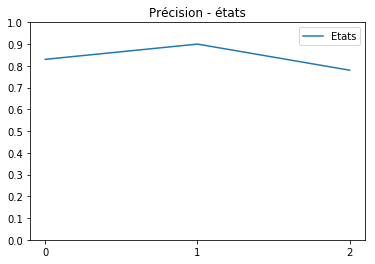

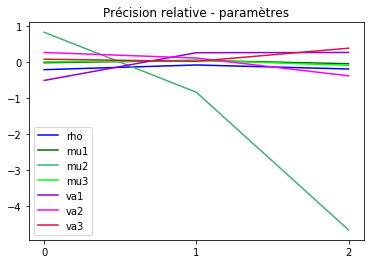

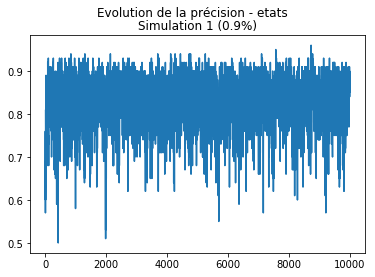

<Figure size 432x288 with 0 Axes>

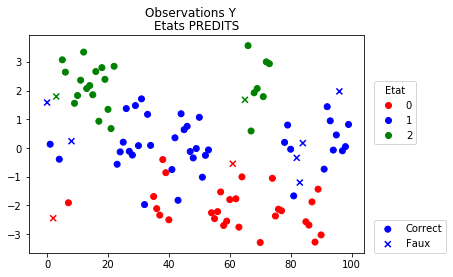

<Figure size 432x288 with 0 Axes>

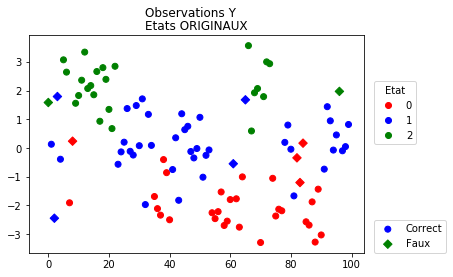

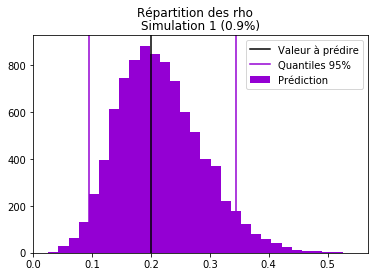

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.09 , 0.34]


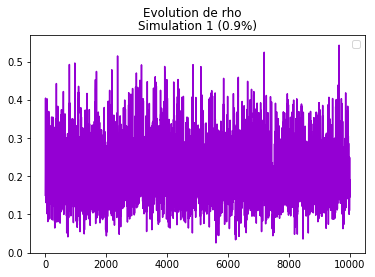

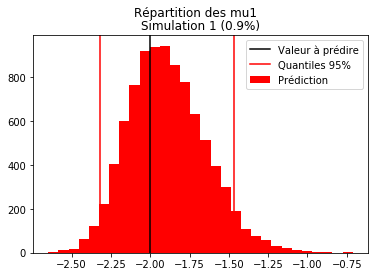

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [-2.32 , -1.47]


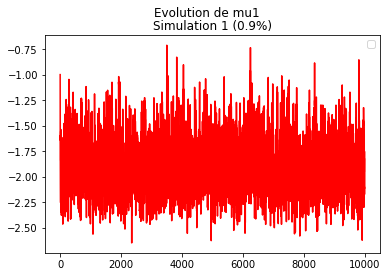

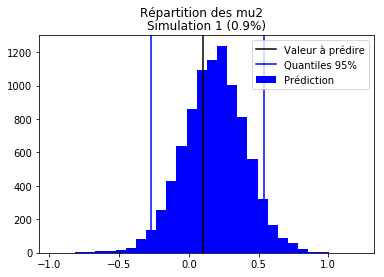

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [-0.27 , 0.54]


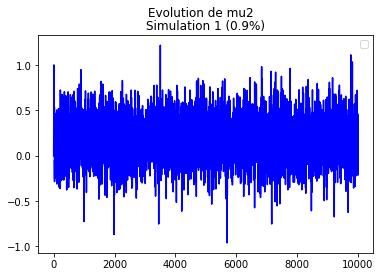

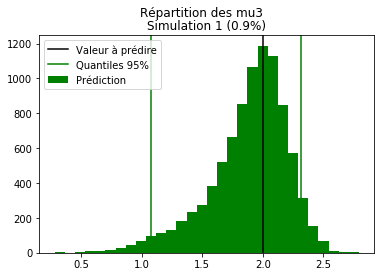

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [1.08 , 2.32]


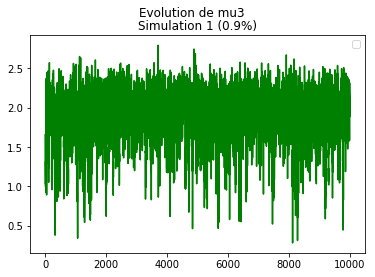

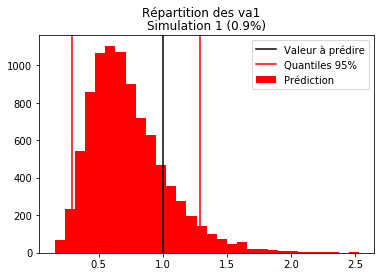

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.3 , 1.29]


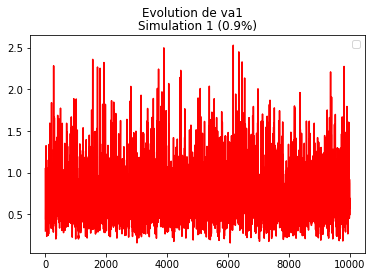

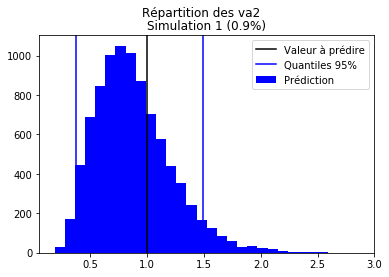

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.37 , 1.5]


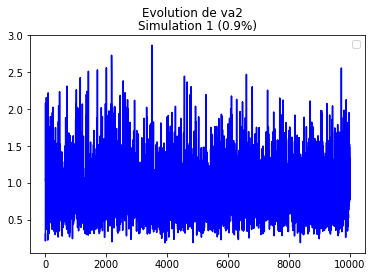

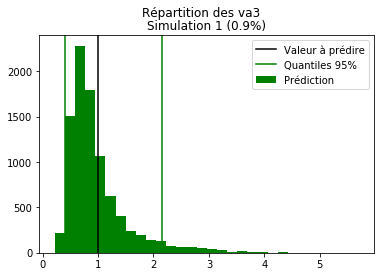

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.4 , 2.15]


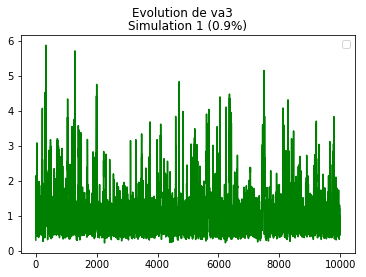

In [48]:
evaluation_algo_trois_etats(n=100, L=10000, N=3,
                            rho_choisi = [0.2,0.2,0.2],
                            esperances_choisi = [[-2,0.1,2]]*3,
                            variances_choisi  = [[1,1,1]]*3)

### Traitement des données expérimentales

#### Récupération des données (observations expérimentales)

On récupère les observations Y qui correspondent à :
$Y = log( \frac {I_{sans \ tumeur}} {I_{avec \ tumeur}})$ </center>

In [250]:
sans_tumeur = pd.read_csv("D:/Téléchargements/X/S2/MAP512 - Projet d'approfondissement/Données/IH431_c57BL6_BALBC.txt",
                         sep = '\t', engine='python')

avec_tumeur = pd.read_csv("D:/Téléchargements/X/S2/MAP512 - Projet d'approfondissement/Données/Lowe9_tumor.txt",
                         sep = '\t', engine='python')

def observations(chrom) :
    
    # on filtre sur le chromosome
    
    sans_tumeur_CHROM = sans_tumeur[sans_tumeur['CHROM']==chrom]
    avec_tumeur_CHROM = avec_tumeur[avec_tumeur['CHROM']==chrom]
    
    # on ne retient que la variable ratio
    abscisse = list(sans_tumeur_CHROM['RowNames'])
    sans = list(sans_tumeur_CHROM['Ratio'])
    avec = list(avec_tumeur_CHROM['Ratio'])
    
    # on renvoie les observations sous la forme désirée 
    quotient = [sans[t]/avec[t] for t in range(len(sans))]
    log_quotient = [np.log(x) for x in quotient]
    
    return(abscisse, log_quotient)

On vérifie que l'on obtient bien les mêmes observations pour le chromosome 5 que dans l'article *(Figure 6)*.

Le premier graphique est celui que nous avons obtenu nous-même, le second graphique est celui de l'article.

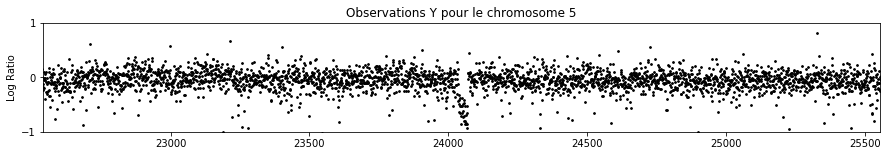

In [251]:
(abscisse, Y) = observations(5)

plt.figure(1, figsize=(15, 2))
plt.scatter(abscisse, Y, color = "black", s = 3)
plt.axis(xmin = 22540, xmax = 25555, ymin = -1, ymax = 1)
plt.ylabel("Log Ratio")
axes = plt.gca()
axes.yaxis.set_ticks([-1,0,1])
plt.title("Observations Y pour le chromosome 5")
plt.show()

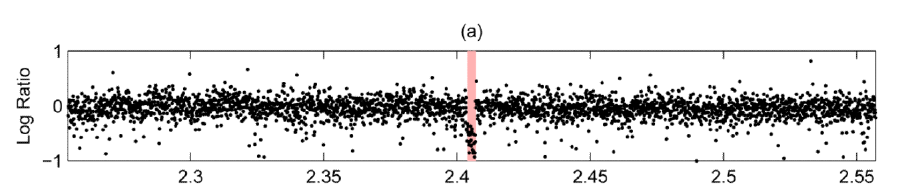

In [55]:
from IPython.display import Image
Image("D:/Téléchargements/X/S2/MAP512 - Projet d'approfondissement/Code/figure_article.PNG")

Les observations sont donc bien les mêmes, on a tronqué la fenêtre graphique selon $x$ et selon $y$ pour mettre en évidence cela.

Il est maintenant temps d'appliquer les algorithmes précédents à ces observations.

#### Application de l'algorithme aux données expérimentales

On applique l'algorithme au chromosome 5.

In [326]:
(abscisse, Y) = observations(5)

(X_comptage, rho, mu1, mu2, mu3, va1, va2, va3, l) = apprentissage_trois_etats(a=0.5,b=1.1,m=0,v=1,c=1,d=1,   Y=Y[966:3981], L=10000)

n = len(Y[966:3981])
s = np.sum(X_comptage[0])

X = [X_comptage[t].index(max(X_comptage[t])) for t in range(n)]

On stocke les états prédits...

In [330]:
df5 = pd.DataFrame()
df5['Abscisse'] = abscisse[966:3981]
df5['Observations'] = Y[966:3981]
df5['Proba Etat 0'] = [x[0]/s for x in X_comptage]
df5['Proba Etat 1'] = [x[1]/s for x in X_comptage]
df5['Proba Etat 2'] = [x[2]/s for x in X_comptage]

df5.to_csv('D:/Téléchargements/X/S2/MAP512 - Projet d\'approfondissement/Résultats/Chromosome 5')

... et les paramètres estimés à chaque étape

In [334]:
d5 = pd.DataFrame()
d5['Itération'] = [i for i in range(1, 10001)]
d5['rho'] = rho
d5['mu1'] = mu1
d5['mu2'] = mu2
d5['mu3'] = mu3
d5['va1'] = va1
d5['va2'] = va2
d5['va3'] = va3

d5.to_csv('D:/Téléchargements/X/S2/MAP512 - Projet d\'approfondissement/Résultats/Chromosome 5_paramètres')

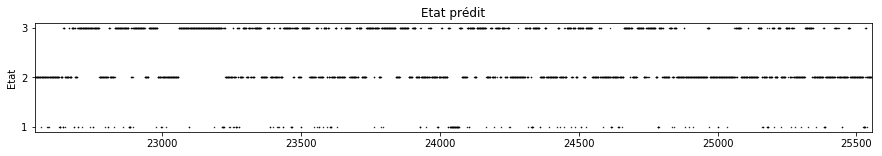

In [65]:
abscisse = df5['Abscisse']
Y = df5['Observations']
etat_1 = df5['Proba Etat 0']
etat_2 = df5['Proba Etat 1']
etat_3 = df5['Proba Etat 2']

def ma(x,y,z):
    l = [x,y,z]
    return l.index(max(l))

X = [ma(etat_1[i],etat_2[i],etat_3[i])+1 for i in range(len(etat_1))]

plt.figure(4, figsize=(15, 2))
plt.scatter(abscisse, X, s = 0.2, color = "black")
plt.axis(xmin = 22540, xmax = 25555)
plt.title("Etat prédit")
plt.ylabel("Etat")
axes = plt.gca()
axes.yaxis.set_ticks([1,2,3])
plt.show()

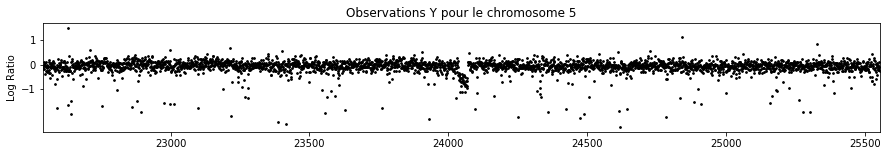

NameError: name 'X_comptage' is not defined

In [64]:
plt.figure(1, figsize=(15, 2))
plt.scatter(abscisse, Y, color = "black", s = 3)
plt.axis(xmin = 22540, xmax = 25555)
plt.ylabel("Log Ratio")
axes = plt.gca()
axes.yaxis.set_ticks([-1.00,0.00,1.00])
plt.title("Observations Y pour le chromosome 5")
plt.show()


def mutation(x):
    if x==2:
        return 0
    else:
        return 1-x
    
probas = [x[0]/s for x in X_comptage]
X_men = [mutation(x) for x in X]

plt.figure(2, figsize=(15, 2))
plt.plot(abscisse[966:3981], probas, linewidth = 0.4, color = "black")
plt.axis(xmin = 22540, xmax = 25555)
plt.title("Déletion prédite")
plt.ylabel("Proba")
plt.show()

plt.figure(3, figsize=(15, 2))
plt.scatter(abscisse[966:3981], X_men, s = 0.2, color = "black")
plt.axis(xmin = 22540, xmax = 25555)
plt.title("Etats prédits (groupé)")
plt.ylabel("Etat")
plt.show()

plt.figure(4, figsize=(15, 2))
plt.scatter(abscisse[966:3981], X, s = 0.2, color = "black")
plt.axis(xmin = 22540, xmax = 25555)
plt.title("Etat prédit")
plt.ylabel("Etat")
axes = plt.gca()
axes.yaxis.set_ticks([1,2,3])
plt.show()


plt.figure(5, figsize=(15, 2))
plt.scatter(abscisse, Y, color = "black", s = 3)
plt.axis(xmin = 22540, xmax = 25555)
plt.ylabel("Log Ratio")
plt.hlines(y=np.mean(mu3[1000:10000]), color = "g", label = "mu3", xmin = 22540, xmax = 25555)
plt.hlines(y=np.mean(mu2[1000:10000]), color = "b", label = "mu2", xmin = 22540, xmax = 25555)
plt.hlines(y=np.mean(mu1[1000:10000]), color = "r", label = "mu1", xmin = 22540, xmax = 25555)
axes = plt.gca()
axes.yaxis.set_ticks([-1.00,0.00,1.00])
plt.title("Observations Y pour le chromosome 5")
plt.legend()
plt.show()



X_color = [(lambda y: "r" if y == 0 else("b" if y == 1 else "g"))(x) for x in X]

plt.figure(6, figsize=(12, 4))
plt.scatter(abscisse[966:3981], Y[966:3981], color = X_color, s = 3)
plt.axis(xmin = 22540, xmax = 25555, ymin = -2.7, ymax = 1.7)
plt.ylabel("Log Ratio")
plt.xlabel("Abscisse")
axes = plt.gca()
axes.yaxis.set_ticks([-1.00,0.00,1.00])
plt.title("Observations Y pour le chromosome 5")
plt.legend()
plt.show()



esperances = [np.mean(mu1[1000:10000]), np.mean(mu2[1000:10000]), np.mean(mu3[1000:10000])]
variances = [np.mean(va1[1000:10000]), np.mean(va2[1000:10000]), np.mean(va3[1000:10000])]
couleurs = ["r","b","g"]
x = list(np.linspace(-2.7,1.7,10000))
y = [[ss.norm.pdf(f,esperances[i], variances[i]**0.5) for f in x] for i in range(3)]

plt.figure(7, figsize=(4,4))
for i in range(3):
    plt.scatter(y[i],x, color = couleurs[i], label = "Etat " + str(i+1), s=1)
plt.xlabel("Densité")
axes = plt.gca()
axes.yaxis.tick_left()
axes.yaxis.set_visible(False)
plt.legend()
plt.show()

In [374]:
np.mean(rho[1000:])

0.13029563079579032

-0.5694914421080722 -0.07422144721841377 0.004559741577780792

0.4604091436132433 0.022685718468759913 0.024867551578849744


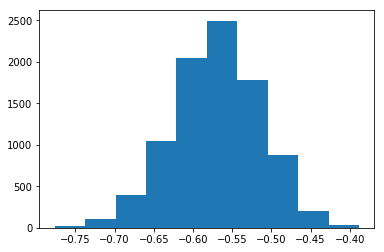

In [375]:
print(np.mean(mu1[1000:]), np.mean(mu2[1000:]), np.mean(mu3[1000:]))
print()
print(np.mean(va1[1000:]), np.mean(va2[1000:]), np.mean(va3[1000:]))

plt.hist(mu1[1000:])
plt.show()

#### Simulation avec les paramètres obtenus

In [61]:
df5 = pd.read_csv("D:/Téléchargements/X/S2/MAP512 - Projet d'approfondissement/Résultats/Seconds calculs/Chromosome 5",
                         sep = ',', engine='python')

d5 = pd.read_csv("D:/Téléchargements/X/S2/MAP512 - Projet d'approfondissement/Résultats/Seconds calculs/Chromosome 5_paramètres",
                         sep = ',', engine='python')

In [52]:
rho = np.mean(d5['rho'][1000:])
mu1 = np.mean(d5['mu1'][1000:])
mu2 = np.mean(d5['mu2'][1000:])
mu3 = np.mean(d5['mu3'][1000:])
va1 = np.mean(d5['va1'][1000:])
va2 = np.mean(d5['va2'][1000:])
va3 = np.mean(d5['va3'][1000:])

1-ème simulation calculée en 1273 mins
rho = 0.13, mu1 = -0.57, mu2 = -0.07, mu3 = 0.0, va1 = 0.46, va2 = 0.02, va3 = 0.02


Précisions

X :  [0.74]

rho :  [0.05]

mu1 :  [0.05]

mu2 :  [0.04]

mu3 :  [3.51]

va1 :  [0.01]

va2 :  [-0.12]

va3 :  [-0.17]


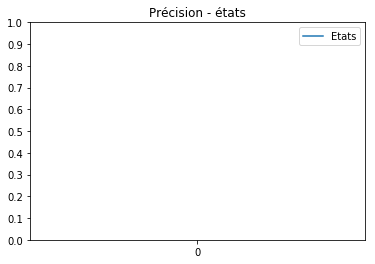

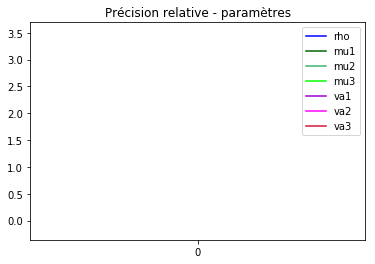

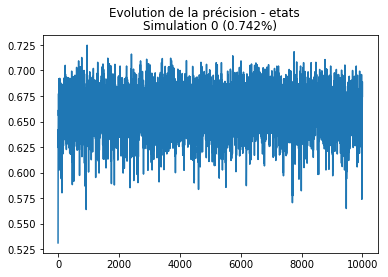

<Figure size 432x288 with 0 Axes>

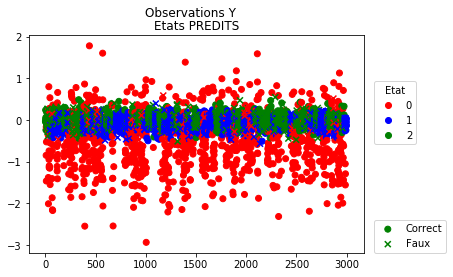

<Figure size 432x288 with 0 Axes>

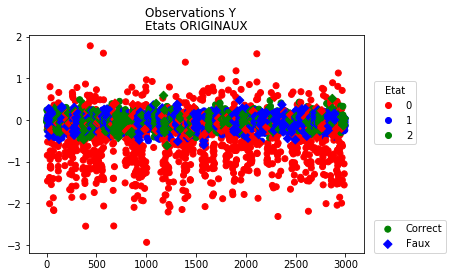

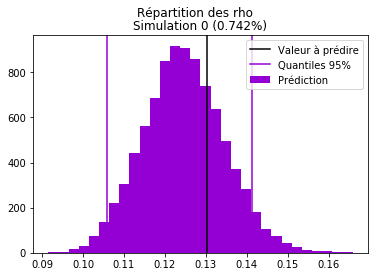

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.11 , 0.14]


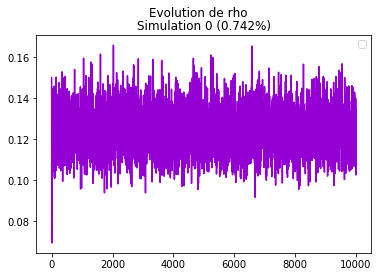

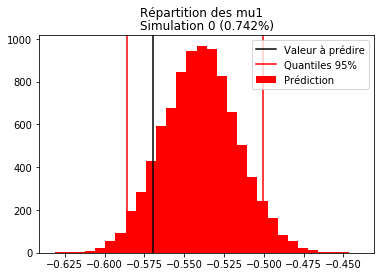

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [-0.59 , -0.5]


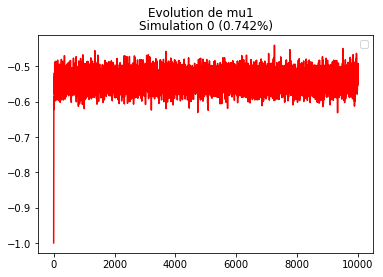

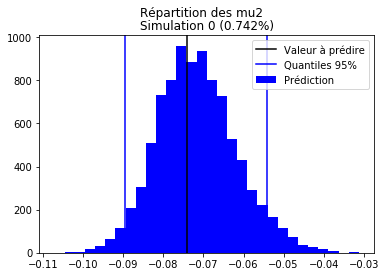

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [-0.09 , -0.05]


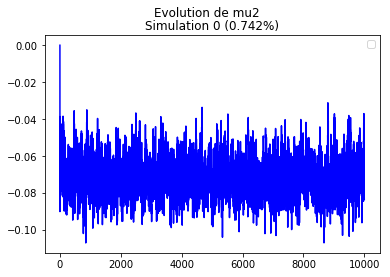

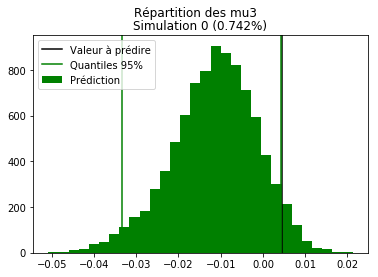

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [-0.03 , 0.0]


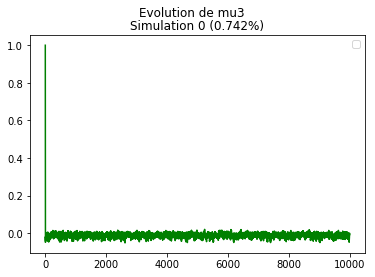

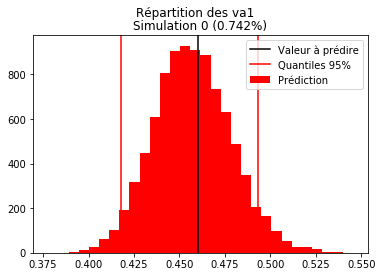

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.42 , 0.49]


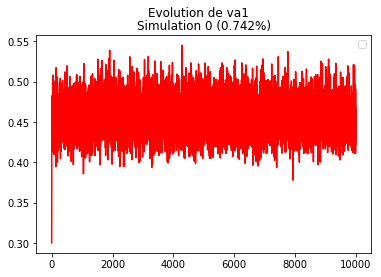

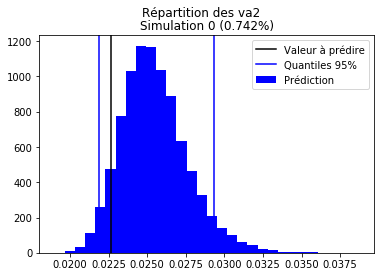

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.02 , 0.03]


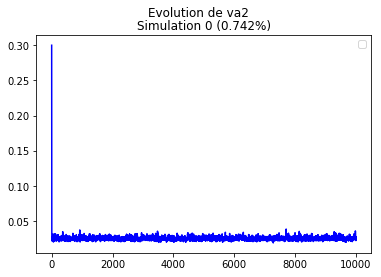

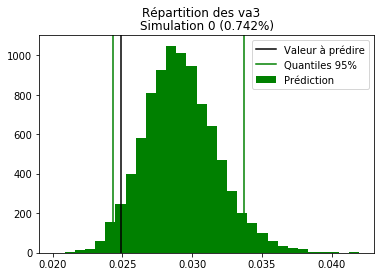

No handles with labels found to put in legend.


Intervalle de crédibilité à 95% : [0.02 , 0.03]


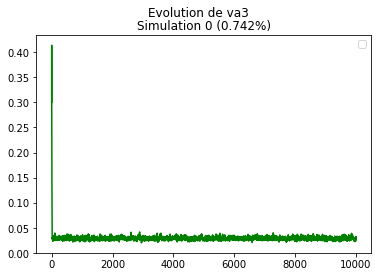

In [55]:
evaluation_algo_trois_etats(n=3000, L=10000, N=1,
                            rho_choisi = [rho],
                            esperances_choisi = [[mu1,mu2,mu3]],
                            variances_choisi  = [[va1,va2,va3]])

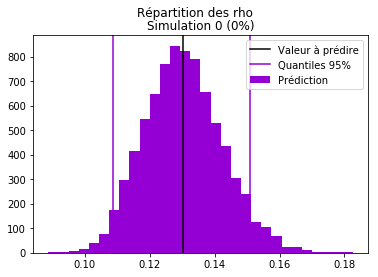

Intervalle de crédibilité à 95% : [0.11 , 0.15]


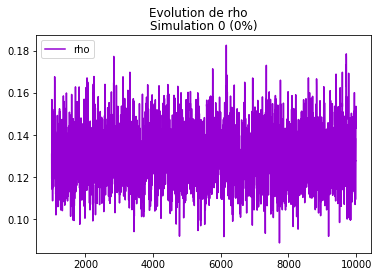

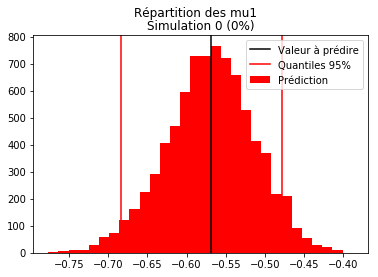

Intervalle de crédibilité à 95% : [-0.68 , -0.48]


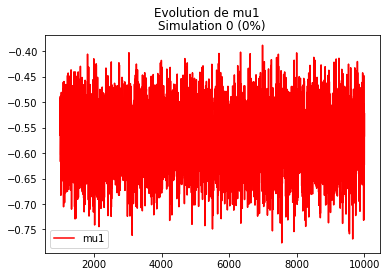

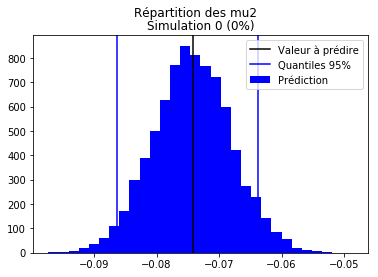

Intervalle de crédibilité à 95% : [-0.09 , -0.06]


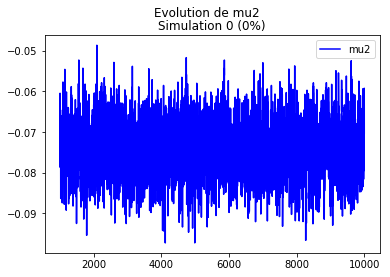

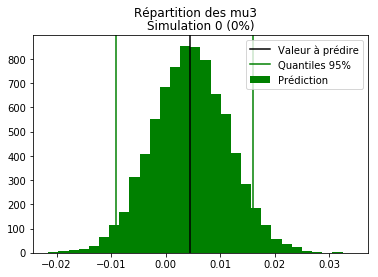

Intervalle de crédibilité à 95% : [-0.01 , 0.02]


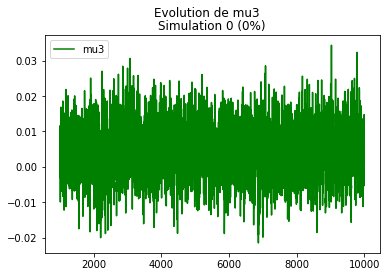

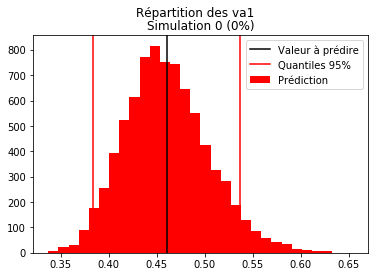

Intervalle de crédibilité à 95% : [0.38 , 0.54]


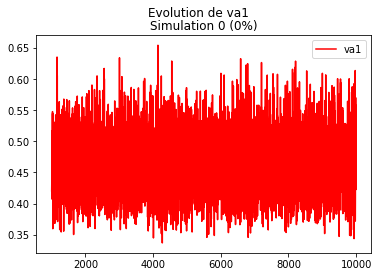

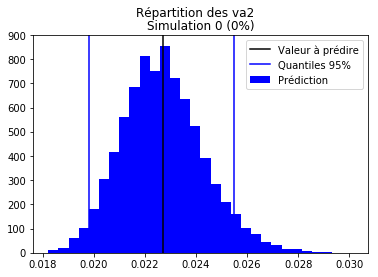

Intervalle de crédibilité à 95% : [0.02 , 0.03]


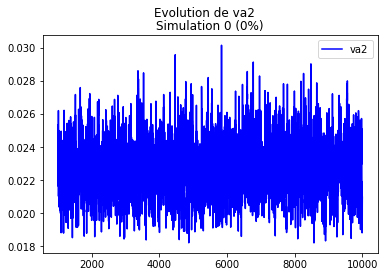

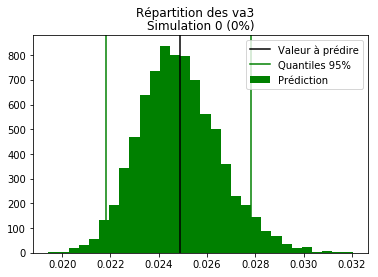

Intervalle de crédibilité à 95% : [0.02 , 0.03]


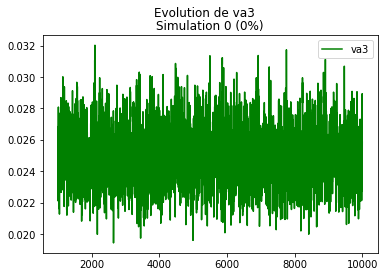

In [72]:
affichage_graphique_resultats("0", "0", 1000,
                                  d5['rho'][1000:], d5['mu1'][1000:], d5['mu2'][1000:], d5['mu3'][1000:],
                                  d5['va1'][1000:], d5['va2'][1000:], d5['va3'][1000:],
                                  np.mean(d5['rho'][1000:]),
                                  [np.mean(d5['mu1'][1000:]), np.mean(d5['mu2'][1000:]), np.mean(d5['mu3'][1000:])],
                                  [np.mean(d5['va1'][1000:]), np.mean(d5['va2'][1000:]), np.mean(d5['va3'][1000:])])

## Bibliographie

[1] LAKSHMI *et al.*, **Mouse genomic representational oligonucleotide microarray analysis: Detection of copy number variations in normal and tumor specimens**, 2006, *Proceedings of the National Academy of Sciences*

[2] YAU *et al.*, **Bayesian Nonparametric Hidden Markov Models with application to the analysis of copy-number-variation in mammalian genomes**, 2011, *J R Stat Soc Series B Stat Methodol*.